In [1]:
import DataLoader
import Training
import HelperFunctions
import pandas as pd 
parameters = {
    # data
    "data_path": "F:/Masterthesis",
    "task": "N170",
    "preprocessing": "heavy",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 28,
    "input_window_samples": 257,
    "seed": 42,
    # classifier
    "lr": 0.001,
    "weight_decay": 0,
    "batch_size": 16,
    "n_epochs": 35,
    "n_splits": 2,
    "model_folder": "models_run2"
}

In [ ]:
for task in ["N170", "N400", "N2pc", "MMN", "P3", "ERN", "LRP"]:
    parameters["task"] = task
    df = DataLoader.load_dataframe(parameters)
    data, labels = DataLoader.create_data_labels(df)
    Training.run_exp(data, labels, parameters)

N170: 0.760258232153262
N400: 0.7488655050281445
N2pc: 0.6415069824861785
MMN: 0.59270724456276
P3: 0.7497592681752525
ERN: 0.8898806306132376
LRP: 0.8179070580013976


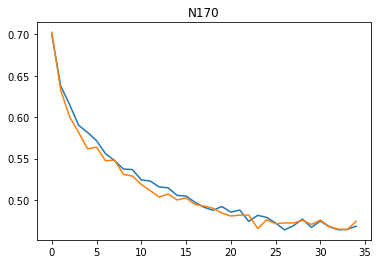

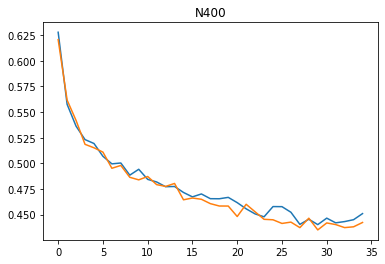

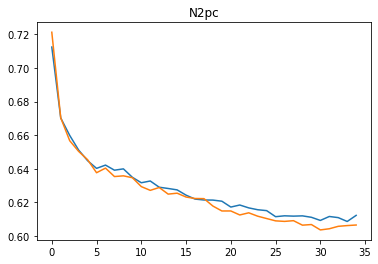

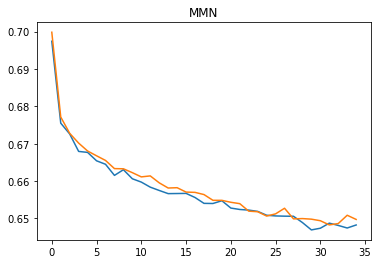

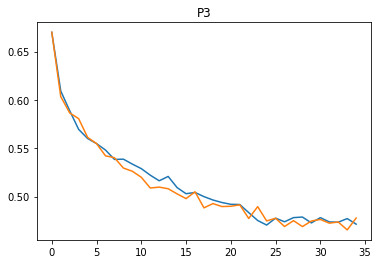

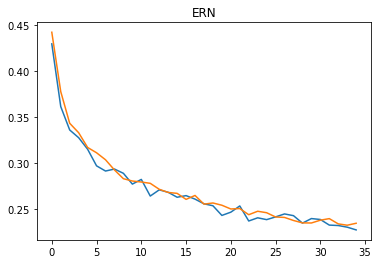

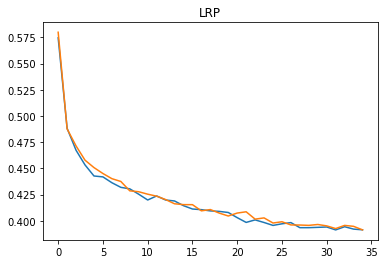

In [3]:
for task in ["N170", "N400", "N2pc", "MMN", "P3", "ERN", "LRP"]:
    parameters["task"] = task
    df = Training.load_exp(parameters)
    print(task+": "+str(df.loc[df.index[-1],"valid_balanced_accuracy"].mean()))
    df["train_loss"].plot(title=task, legend=None)

In [5]:
results = []
for model in ["eegnet", "shallow", "deep"]:
    parameters["model"] = model
    for preprocessing in ["light", "medium", "heavy"]:
        parameters["preprocessing"] = preprocessing
        for task in ["N170", "N400", "N2pc", "MMN", "P3", "ERN", "LRP"]:
            parameters["task"] = task
            df = Training.load_exp(parameters)
            results.append([model,preprocessing,task,df.loc[df.index[-1],"valid_accuracy"].mean()])
            #print(model+", "+preprocessing+", "+task+": "+str(df.loc[df.index[-1],"valid_balanced_accuracy"].mean()))
df_results = pd.DataFrame(results, columns=["Model", "Preprocessing", "Task", "Validation Balanced Accuracy"])

In [6]:
#.reset_index(drop=True)
df_results[df_results["Preprocessing"]=="light"].pivot(
    index="Task", 
    columns="Model", 
    values="Validation Balanced Accuracy").style.highlight_max(color = 'lightgreen', axis = 1)

Model,deep,eegnet,shallow
Task,,,
ERN,0.937072,0.921651,0.926012
LRP,0.811059,0.815421,0.760125
MMN,0.658086,0.660953,0.639607
N170,0.782759,0.758190,0.724569
N2pc,0.671022,0.674003,0.646951
N400,0.746499,0.769608,0.746499
P3,0.817308,0.808687,0.793435


In [7]:
df_results[df_results["Model"]=="eegnet"].pivot(
    index="Task", 
    columns="Preprocessing", 
    values="Validation Balanced Accuracy").style.highlight_max(color = 'lightgreen', axis = 1)

Preprocessing,heavy,light,medium
Task,,,
ERN,0.918380,0.921651,0.926324
LRP,0.817913,0.815421,0.818069
MMN,0.666560,0.660953,0.662355
N170,0.759914,0.758190,0.757328
N2pc,0.641220,0.674003,0.666437
N400,0.749300,0.769608,0.758403
P3,0.794098,0.808687,0.792772


In [8]:
df_results[df_results["Model"]=="deep"].pivot(
    index="Task", 
    columns="Preprocessing", 
    values="Validation Balanced Accuracy").style.highlight_max(color = 'lightgreen', axis = 1)

Preprocessing,heavy,light,medium
Task,,,
ERN,0.931153,0.937072,0.934735
LRP,0.814642,0.811059,0.810592
MMN,0.662419,0.658086,0.665477
N170,0.789224,0.782759,0.782328
N2pc,0.653141,0.671022,0.675837
N400,0.750000,0.746499,0.752101
P3,0.811671,0.817308,0.818966


In [9]:
df_results[df_results["Model"]=="shallow"].pivot(
    index="Task", 
    columns="Preprocessing", 
    values="Validation Balanced Accuracy").style.highlight_max(color = 'lightgreen', axis = 1)

Preprocessing,heavy,light,medium
Task,,,
ERN,0.935202,0.926012,0.915421
LRP,0.761526,0.760125,0.761215
MMN,0.637186,0.639607,0.661718
N170,0.728017,0.724569,0.744828
N2pc,0.614168,0.646951,0.646034
N400,0.742997,0.746499,0.751401
P3,0.803382,0.793435,0.779178


In [3]:
df = DataLoader.load_dataframe(parameters)
data, labels = DataLoader.create_data_labels(df)

Reading F:\Masterthesis\N170\1\1_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 174847  =      0.000 ...   682.996 secs...
Reading F:\Masterthesis\N170\2\2_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 170751  =      0.000 ...   666.996 secs...
Reading F:\Masterthesis\N170\3\3_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 144895  =      0.000 ...   565.996 secs...
Reading F:\Masterthesis\N170\4\4_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 162303  =      0.000 ...   633.996 secs...
Reading F:\Masterthesis\N170\5\5_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 150783  =      0.000 ...   588.996 secs...
Reading F:\Masterthesis\N170\6\6_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 132351  =      0.000 ...   516.996 secs...
Reading F:\Masterthesis\N170\7\7_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 147455  =      0.000 ...   575.996 secs...
Reading F:\Masterthesis\N170\8\8_N170_shifted_ds_reref_ucbip_hpfilt.fdt
Reading 0 ... 201215  =  

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 257 original time points ...
0 bad epochs dropped


C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
156 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 156 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
149 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
154 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
148 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 148 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Not setting metadata
Not setting metadata
140 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 140 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
148 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
148 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 148 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
C:\Users\vapor\Documents\Masterthesis\notebook\DataLoader.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
